In [28]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [29]:
data = pd.read_pickle('DR_Data/rentals.pickle')
'''
X=np.array([data.pickup_zone, data.month, data.weekday, data.air_temperature, data.rain_duration, data.rain_intensity, data.GHI]).T
y=np.array(data.dropoff_zone).T

y = data.dropoff_zone
X = data.drop(['created_at','finished_at','pickup_hub_id','dropoff_hub_id','user_id','dropoff_zone'], axis=1)
'''
X=np.array([data.pickup_zone, data.month_sin,data.month_cos , data.weekday_sin,data.weekday_cos,data.hour_sin,data.hour_cos, data.air_temperature, data.rain_duration, data.rain_intensity, data.GHI]).T
y=np.array(data.dropoff_zone).T
weights=np.zeros(100)
for e in range(len(X[:,0])):
    weights[int(X[e,0])]+=1
    if X[e,0]== X[-1,0]:
        weights = weights/sum(weights)
        weights = 1 - weights

print(y)  

[46 74 91 ... 37 91 51]


In [30]:
# one hot encoding
num_zones = int(max(X[:,0])+1)
num_months = int(max(X[:,1])+1)
num_days = int(max(X[:,2])+1) 
weather=True
cycle = True
# RBF Encoding
RBF_Encoding=True
if RBF_Encoding:
    Euc_distances_sq=np.load('DR_Data/Zone_distances.npy')
    #Gamma = 1/2*sigma^2 and is a tuning parameter
    gamma=0.1
    Euc_distances=np.exp(-Euc_distances_sq*gamma)

num_features = int(num_zones+num_months+num_days)
if weather:
    X_enc=np.zeros((int(X.shape[0]),num_features+4))
else:
    X_enc=np.zeros((int(X.shape[0]),num_features))
for i in range(len(X)):
    i=int(i)
    if RBF_Encoding:
        X_enc[i][:num_zones] = Euc_distances_sq[int(X[i,0])] # zone
    else:
        X_enc[i][int(X[i,0])] = 1 # zone
    if cycle:
        X_enc[i,num_zones:num_zones+6]=X[i,1:7]
        if weather:
            X_enc[i,num_features:]=X[i,7:] #Encoding weather data
            
    else:
        X_enc[i][int(X[i,1])+num_zones] = 1 # month
        X_enc[i][int(X[i,2])+num_zones+num_months] = 1 # days
        if weather:
            X_enc[i,num_features:]=X[i,3:] #Encoding weather data

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_enc, y, test_size=0.1, random_state=2)

In [32]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

In [33]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


**BUILDING MODEL**

In [34]:
# Hyperparameters
num_classes = num_zones
num_l1 = 128
num_l2 = 128
num_l3 = 128

learning_rate = 1e-6
weight_decay = 0

class Net(nn.Module):
    def __init__(self, num_features, num_hidden1, num_hidden2, num_output):
        super(Net, self).__init__()
        # input layer
        if weather:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1, num_features+4)))
        else:
            self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer 1
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        # hidden layer 2
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.Tanh()
        # define dropout to reduce overfitting
        self.drop = torch.nn.Dropout(p=0.5)
        # define batchnorm
        self.batch1 = torch.nn.BatchNorm1d(num_hidden1)
        self.batch2 = torch.nn.BatchNorm1d(num_hidden2)
        
    def forward(self, x):
        # forward prop
        #x=x.type(torch.FloatTensor)
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        #x = self.drop(x)
        x = self.batch1(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = self.batch2(x)
        x = F.linear(x, self.W_3, self.b_3)
        # dropout
        
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_l2, num_classes)
if use_cuda:
    net.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights.astype(float)))

Epoch  1 : Train Loss 0.899146 , Train acc 0.015449, Valid acc 0.015714
Epoch  3 : Train Loss 0.898999 , Train acc 0.015366, Valid acc 0.015625
Epoch  5 : Train Loss 0.898832 , Train acc 0.015894, Valid acc 0.016246
Epoch  7 : Train Loss 0.898642 , Train acc 0.016821, Valid acc 0.017401
Epoch  9 : Train Loss 0.898427 , Train acc 0.017021, Valid acc 0.017667
Epoch 11 : Train Loss 0.898184 , Train acc 0.022754, Valid acc 0.023393
Epoch 13 : Train Loss 0.897910 , Train acc 0.029736, Valid acc 0.029830
Epoch 15 : Train Loss 0.897602 , Train acc 0.048608, Valid acc 0.049139
Epoch 17 : Train Loss 0.897255 , Train acc 0.048862, Valid acc 0.049316
Epoch 19 : Train Loss 0.896873 , Train acc 0.049272, Valid acc 0.049627
Epoch 21 : Train Loss 0.896466 , Train acc 0.049478, Valid acc 0.050426
Epoch 23 : Train Loss 0.896052 , Train acc 0.049487, Valid acc 0.050426
Epoch 25 : Train Loss 0.895646 , Train acc 0.049619, Valid acc 0.050471
Epoch 27 : Train Loss 0.895255 , Train acc 0.055483, Valid acc 0

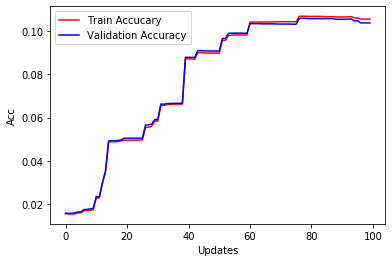

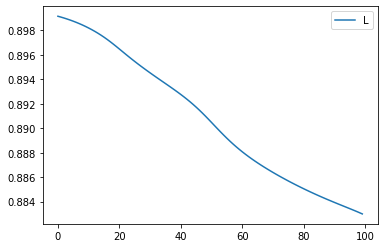

In [35]:
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 100
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = get_variable(Variable(torch.from_numpy(X_train[slce])).type(torch.FloatTensor))
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = get_variable(Variable(torch.from_numpy(y_train[slce]).long()))
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = get_variable(Variable(torch.from_numpy(X_train[slce])).type(torch.FloatTensor))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce])
        train_preds += list(get_numpy(preds))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = get_variable(Variable(torch.from_numpy(X_valid[slce])).type(torch.FloatTensor))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(get_numpy(preds))
        val_targs += list(y_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 2 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.figure()
plt.plot(losses)
plt.legend('Loss')

In [36]:
#torch.save(net,'FFNN_months_days.pt')
#output = net(get_variable(Variable(torch.from_numpy(X_valid_enc))).type(torch.FloatTensor))
#plt.plot(output[10].detach().numpy())
#print(np.argmax(X_valid_enc[0]))
#print(y_train[10])